In [ ]:
import tensorflow as tf
import pandas as pd
import os, librosa
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.text import Tokenizer
import librosa
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences
!pip install gensim
import gensim.downloader as api

print(librosa.__version__)

0.11.0


In [ ]:
def load_audio_for_yamnet(path, max_duration=20):
    SAMPLE_RATE = 16000  # cuz YAMNet
    audio, sr = librosa.load(path, sr=SAMPLE_RATE, mono=True)

    max_samples = SAMPLE_RATE * max_duration
    if len(audio) > max_samples:
        audio = audio[:max_samples]
    else:
        audio = np.pad(audio, (0, max_samples - len(audio)), mode="constant")

    if np.max(np.abs(audio)) > 0:
        audio = audio / np.max(np.abs(audio))

    audio_tensor = tf.constant(audio, dtype=tf.float32)
    return audio_tensor

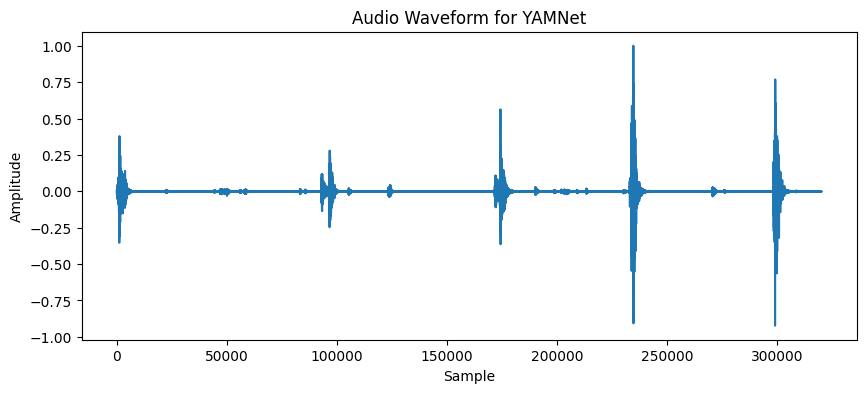

TensorShape([320000])

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(load_audio_for_yamnet(path='/content/drive/MyDrive/clothov21/audio/0605door.wav', max_duration=20))
plt.title('Audio Waveform for YAMNet')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

load_audio_for_yamnet(path='/content/drive/MyDrive/clothov21/audio/0605door.wav', max_duration=20).shape

In [ ]:

df_eval = pd.read_csv("/content/drive/MyDrive/clothov21/clotho_captions_evaluation.csv")
df_val = pd.read_csv("/content/drive/MyDrive/clothov21/clotho_captions_development.csv")
df = pd.concat([df_eval, df_val], ignore_index=True)

df = df.melt(id_vars=["file_name"],
                  value_vars=["caption_1","caption_2","caption_3","caption_4"],
                  var_name="caption_id", value_name="caption_text")

df["caption_in"] = df["caption_text"].apply(lambda x: "<sos> " + x)
df["caption_out"] = df["caption_text"].apply(lambda x: x + " <eos>")
df = df.drop(columns=["caption_id", "caption_text"])

df

,file_name,caption_in,caption_out
0,Santa Motor.wav,<sos> A machine whines and squeals while rhyth...,A machine whines and squeals while rhythmicall...
1,Radio Garble.wav,<sos> A radio dispatcher and an officer are co...,A radio dispatcher and an officer are communic...
2,Radio Fuzz for Old Radio Broadcast FF233.wav,<sos> A radio tuner has been positioned in bet...,A radio tuner has been positioned in between r...
3,toy rattle 2.wav,<sos> A person winding up a device and then ji...,A person winding up a device and then jingling...
4,Blade Big.wav,<sos> A person is pulling silverware out of th...,A person is pulling silverware out of the dish...
...,...,...,...
15747,"Crickets calling at night, UK.wav",<sos> Crickets chirp in the background as a so...,Crickets chirp in the background as a soft win...
15748,"Rain On Town Square, South Germany.wav",<sos> Two people are outside talking while it ...,Two people are outside talking while it is rai...
15749,amazon 04.wav,<sos> An engine runs as birds chirp and sing.,An engine runs as birds chirp and sing. <eos>
15750,steps come and go on stone ground in a village...,<sos> Someone walks across a hard surface as b...,Someone walks across a hard surface as birds c...


In [ ]:
import pickle

tokenizer = Tokenizer(oov_token="<unk>")

tokenizer.fit_on_texts(df["caption_in"].tolist() + df["caption_out"].tolist())
VOCAB_SIZE = len(tokenizer.word_index) + 1  # +1 for padding
print(VOCAB_SIZE)

word2idx = tokenizer.word_index
idx2word = {v: k for k, v in word2idx.items()}

4278
✅ Saved:
  - tokenizer.pkl
  - word_mappings.pkl
  - model_metadata.pkl
  - Vocab size: 4278


In [ ]:
seq_in  = tokenizer.texts_to_sequences(df["caption_in"])
seq_out = tokenizer.texts_to_sequences(df["caption_out"])
max_len = max(max(len(s) for s in seq_in), max(len(s) for s in seq_out))
X_caption = pad_sequences(seq_in,  maxlen=max_len, padding="post")
y_caption = pad_sequences(seq_out, maxlen=max_len, padding="post")

print("MAXIMUM LENGTH OF CAPTION IS: " ,max_len)
X_caption.shape

MAXIMUM LENGTH OF CAPTION IS:  21


(15752, 21)

In [ ]:
import gensim.downloader as api

# Load GloVe model (downloads automatically)
glove_model = api.load('glove-wiki-gigaword-300')

[==================================================] 100.0% 376.1/376.1MB downloaded


In [ ]:
EMBED_DIM = 300
embedding_matrix = np.zeros((VOCAB_SIZE, EMBED_DIM))
oov_words = []
for word, i in word2idx.items():
    if word == '<unk>':
        embedding_matrix[i] = np.mean(glove_model.vectors, axis=0)
    elif word == 'sos':
      embedding_matrix[i] = glove_model['start']
    elif word == 'eos':
      embedding_matrix[i] = glove_model['end']
    elif word in glove_model:
        embedding_matrix[i] = glove_model[word]
    else:
        embedding_matrix[i] = np.random.normal(0, 0.1, EMBED_DIM)
        oov_words.append(word)
del glove_model
embedding_matrix.shape

(4278, 300)

# **`RUN THE NEXT CELL ONLY TO MAKE AUDIO EMBEDDINGS AND SAVE IT!`**


In [ ]:
# import tensorflow_hub as hub
# from tqdm import tqdm
# import numpy as np

# yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')
# unique_files = df["file_name"].unique()

# # Pre-calculate dimensions
# sample_audio = load_audio_for_yamnet(f"/content/drive/MyDrive/clothov21/audio/{unique_files[0]}")
# _, sample_emb, _ = yamnet_model(sample_audio)
# time_frames, embed_dim = sample_emb.shape

# print(f"Each audio file: {time_frames} frames × {embed_dim} dimensions")

# # Create memory-mapped array
# total_samples = len(df)
# embeddings_mmap = np.memmap(
#     "/content/drive/MyDrive/clothov21/X_audio_embeddings.dat",
#     dtype='float32',
#     mode='w+',
#     shape=(total_samples, time_frames, embed_dim)
# )

# # Process files and store directly to disk
# embedding_dict = {}
# for fname in tqdm(unique_files, desc="Processing audio"):
#     try:
#         audio_tensor = load_audio_for_yamnet(f"/content/drive/MyDrive/clothov21/audio/{fname}")
#         _, embeddings, _ = yamnet_model(audio_tensor)
#         embedding_dict[fname] = embeddings.numpy()
#     except Exception as e:
#         print(f"Error processing {fname}: {e}")

# # Map to final array
# for idx, (_, row) in enumerate(tqdm(df.iterrows(), desc="Mapping to array")):
#     embeddings_mmap[idx] = embedding_dict[row['file_name']]

# # Save as numpy array
# np.save("/content/drive/MyDrive/clothov21/X_audio_embeddings.npy", embeddings_mmap)
# del embeddings_mmap  # Free memory

# --

In [ ]:
X_audio_embeddings = np.load("/content/drive/MyDrive/clothov21/X_audio_embeddings.npy")

# ***THE ACTUAL NEURAL NETWORK!***

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import tensorflow_hub as hub

# ------------------ Hyperparameters ------------------
ENC_LSTM_UNITS = 512
DEC_UNITS      = 512
EMBED_DIM      = 300
ATTN_UNITS     = 512
DROPOUT        = 0.4

# ------------------ Embedded Inputs ------------------
input_audio_embeddings = layers.Input(shape=(None, 1024), name="audio_input")  # YAMNet outputs 1024-dim
input_caption = layers.Input(shape=(None,), dtype="int32", name="caption_input")

# ------------------ Encoder LSTM ------------------
enc_lstm = layers.Bidirectional(
    layers.LSTM(ENC_LSTM_UNITS, return_sequences=True),
    name="encoder_lstm"
)(input_audio_embeddings)  # (B, T, 2*ENC_LSTM_UNITS)

enc_lstm = layers.Dropout(DROPOUT)(enc_lstm)
enc_proj = layers.Dense(ENC_LSTM_UNITS, activation="relu", name="enc_proj")(enc_lstm)

# ------------------ Decoder ------------------
caption_embedding = layers.Embedding(VOCAB_SIZE, EMBED_DIM, weights=[embedding_matrix], trainable = True)(input_caption)
dec_lstm = layers.LSTM(DEC_UNITS, return_sequences=True, name="decoder_lstm")(caption_embedding)
dec_lstm = layers.Dropout(DROPOUT)(dec_lstm)

# ------------------ Attention ------------------
context = layers.AdditiveAttention(name="attention")([dec_lstm, enc_proj])

# Merge context + decoder hidden state
merged = layers.Concatenate(axis=-1)([dec_lstm, context])
merged = layers.Dense(ATTN_UNITS, activation="tanh")(merged)
merged = layers.Dropout(DROPOUT)(merged)

# ------------------ Output ------------------
logits = layers.TimeDistributed(
    layers.Dense(VOCAB_SIZE),
    name="token_logits"
)(merged)

# ------------------ Build ------------------
model = Model(inputs=[input_audio_embeddings, input_caption], outputs=logits, name="audio_captioning_full")

model.compile(
    optimizer=tf.keras.optimizers.Adam(2e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  # Add this!
    metrics=["accuracy"]
)

model.summary()

Model: "audio_captioning_full"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ caption_input       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ audio_input         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, None, 300) │  1,283,400 │ caption_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm        │ (None, None,      │  6,295,552 │ audio_input[0][0] │
│ (Bidirectional)     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ (None, None, 512) │  1,665,024 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, None,      │          0 │ encoder_lstm[0][… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, None, 512) │          0 │ decoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_proj (Dense)    │ (None, None, 512) │    524,800 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, None, 512) │        512 │ dropout_1[0][0],  │
│ (AdditiveAttention) │                   │            │ enc_proj[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, None,      │          0 │ dropout_1[0][0],  │
│ (Concatenate)       │ 1024)             │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, None, 512) │    524,800 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, None, 512) │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_logits        │ (None, None,      │  2,194,614 │ dropout_2[0][0]   │
│ (TimeDistributed)   │ 4278)             │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 12,488,702 (47.64 MB)

 Trainable params: 12,488,702 (47.64 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print("X_audio_embeddings shape/dtype:", X_audio_embeddings.shape, X_audio_embeddings.dtype)
print("X_caption shape/dtype:", X_caption.shape, X_caption.dtype)
print("y_caption shape/dtype:", y_caption.shape, y_caption.dtype)

# Make sure they're the right types:
X_audio_embeddings = X_audio_embeddings.astype(np.float32)
X_caption = X_caption.astype(np.int32)
y_caption = y_caption.astype(np.int32)

X_audio_embeddings shape/dtype: (15752, 41, 1024) float32
X_caption shape/dtype: (15752, 21) int32
y_caption shape/dtype: (15752, 21) int32


In [ ]:
history = model.fit(
    [X_audio_embeddings, X_caption], y_caption,
    batch_size=32,
    epochs=25,
    validation_split = 0.2
)

model.save('/content/drive/MyDrive/clothov21/audio_captioning_model_best.keras')

Epoch 1/25
394/394 ━━━━━━━━━━━━━━━━━━━━ 815s 2s/step - accuracy: 0.4544 - loss: 4.1087 - val_accuracy: 0.5326 - val_loss: 2.9475
Epoch 2/25
394/394 ━━━━━━━━━━━━━━━━━━━━ 828s 2s/step - accuracy: 0.5513 - loss: 2.8262 - val_accuracy: 0.5538 - val_loss: 2.6242
Epoch 3/25
394/394 ━━━━━━━━━━━━━━━━━━━━ 793s 2s/step - accuracy: 0.5727 - loss: 2.5345 - val_accuracy: 0.5699 - val_loss: 2.4605
Epoch 4/25
394/394 ━━━━━━━━━━━━━━━━━━━━ 799s 2s/step - accuracy: 0.5858 - loss: 2.3611 - val_accuracy: 0.5788 - val_loss: 2.3553
Epoch 5/25
394/394 ━━━━━━━━━━━━━━━━━━━━ 766s 2s/step - accuracy: 0.5959 - loss: 2.2395 - val_accuracy: 0.5855 - val_loss: 2.2772
Epoch 6/25
394/394 ━━━━━━━━━━━━━━━━━━━━ 768s 2s/step - accuracy: 0.6039 - loss: 2.1363 - val_accuracy: 0.5924 - val_loss: 2.2175
Epoch 7/25
394/394 ━━━━━━━━━━━━━━━━━━━━ 770s 2s/step - accuracy: 0.6085 - loss: 2.0702 - val_accuracy: 0.5984 - val_loss: 2.1718
Epoch 8/25
394/394 ━━━━━━━━━━━━━━━━━━━━ 774s 2s/step - accuracy: 0.6137 - loss: 2.0044 - val_accu

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/clothov21/audio_captioning_model_best.keras')

In [71]:
#------- TEST --------

audio_num = 599

sample_audio = X_audio_embeddings[audio_num]
sample_file = df.iloc[audio_num]['file_name']

def test_caption(audio_embedding, max_len=20):
    sos_token = tokenizer.word_index.get('sos', 1)
    eos_token = tokenizer.word_index.get('eos', 2)
    caption = [sos_token]

    audio_batch = np.expand_dims(audio_embedding, 0)

    for _ in range(max_len):
        caption_input = np.array([caption])
        predictions = model.predict([audio_batch, caption_input], verbose=0)

        next_token = np.argmax(predictions[0, len(caption)-1, :])

        if next_token == eos_token:
            break
        caption.append(next_token)

    words = []
    for token in caption[1:]:
        if token in idx2word:
            word = idx2word[token]
            if word not in ['<sos>', '<eos>', '<pad>']:
                words.append(word)

    return ' '.join(words)

print(f"Audio file: {sample_file}")
print(f"Generated caption: '{test_caption(sample_audio)}'")

# 4. Compare with true caption (optional)
true_caption = df.iloc[audio_num]['caption_in']
print(f"True caption: '{true_caption}'")

Audio file: Juicer Shredding and Shutting Down.wav
Generated caption: 'a machine is running at a constant speed and then slowing down'
True caption: '<sos> A spinning motor runs higher and lower repeatedly.'


In [72]:
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
!pip install pycocoevalcap
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.bleu.bleu import Bleu
import numpy as np

def calculate_metrics(model, X_test, y_test_captions, num_samples=1000):
    predictions = []
    references = []

    for i in range(min(num_samples, len(X_test))):
        pred_caption = test_caption(X_test[i])
        predictions.append(pred_caption.split())

        ref_tokens = [idx2word.get(token, '') for token in y_test_captions[i]
                     if token != 0 and idx2word.get(token, '') not in ['<sos>', '<eos>', 'sos', 'eos']]
        references.append([ref_tokens])

        if i % 100 == 0:
            print(f"Processed {i}/{num_samples} samples...")

    bleu1 = corpus_bleu(references, predictions, weights=(1, 0, 0, 0))
    bleu4 = corpus_bleu(references, predictions, weights=(0.25, 0.25, 0.25, 0.25))

    print(f"BLEU-1: {bleu1:.3f}")
    print(f"BLEU-4: {bleu4:.3f}")

    return bleu1, bleu4, predictions, references

bleu1, bleu4, preds, refs = calculate_metrics(
    model,
    X_audio_embeddings[-1000:],  # Use last 1000 samples as test
    y_caption[-1000:],
    num_samples=500
)


Processed 0/500 samples...
Processed 100/500 samples...
Processed 200/500 samples...
Processed 300/500 samples...
Processed 400/500 samples...
BLEU-1: 0.260
BLEU-4: 0.043
